**Changing batch size from 32 to 64, changing learning rate**

In [ ]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import sys
import os

In [ ]:

%matplotlib inline

import numpy as np

import nibabel as nib
import glob

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [ ]:
y_train = np.load('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa_data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/image_flair_combined.npy')
#x_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_images.npy')
x_train = np.load('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa_data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/mask_combined.npy')
#y_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_masks.npy')

In [ ]:
image2D = []
for i in range(210):
  for j in range(128):
    image2D.append(x_train[i,:,:,j])

x_train = np.array(image2D)

In [ ]:
mask2D = []
for i in range(210):
  for j in range(128):
    mask2D.append(y_train[i,:,:,j])
y_train = np.array(mask2D)

In [ ]:
x_train.shape, y_train.shape

((26880, 128, 128), (26880, 128, 128))

<function matplotlib.pyplot.imshow>

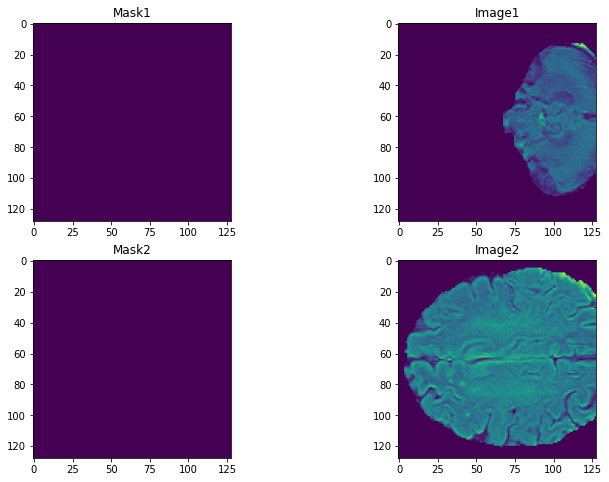

In [ ]:
rand=np.random.randint(0,26880 )
rand_2=np.random.randint(0,26880)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Mask1')
plt.imshow(x_train[rand,:,:])
plt.subplot(222)
plt.title('Image1')
plt.imshow(y_train[rand,:,:])

plt.subplot(223)
plt.title('Mask2')
plt.imshow(x_train[rand_2,:,:])
plt.subplot(224)
plt.title('Image2')
plt.imshow(y_train[rand_2,:,:])

plt.imshow

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization
#from keras import layers
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20)

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((21504, 128, 128), (5376, 128, 128), (21504, 128, 128), (5376, 128, 128))

In [ ]:
import random

<function matplotlib.pyplot.imshow>

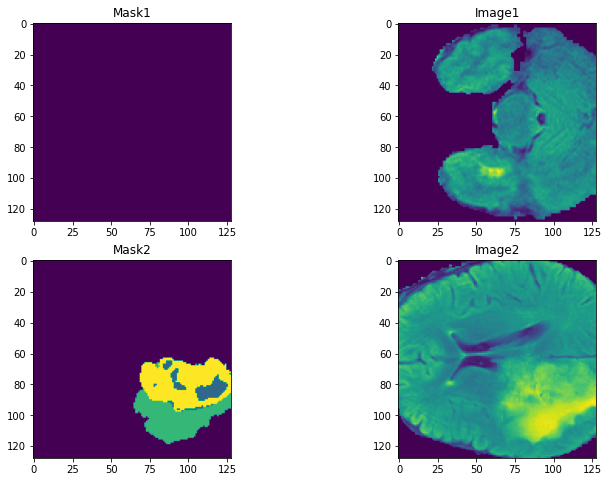

In [ ]:
rand=np.random.randint(0,21504 )
rand_2=np.random.randint(0,5376)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Mask1')
plt.imshow(x_train[rand,:,:])
plt.subplot(222)
plt.title('Image1')
plt.imshow(y_train[rand,:,:])

plt.subplot(223)
plt.title('Mask2')
plt.imshow(x_val[rand_2,:,:])
plt.subplot(224)
plt.title('Image2')
plt.imshow(y_val[rand_2,:,:])

plt.imshow

In [ ]:
x_train = tf.keras.utils.to_categorical(x_train)
x_val = tf.keras.utils.to_categorical(x_val)

In [ ]:
y_train = np.expand_dims(y_train, axis = 3)
y_val = np.expand_dims(y_val, axis = 3)

In [ ]:
del mask2D, image2D

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((21504, 128, 128, 4),
 (5376, 128, 128, 4),
 (21504, 128, 128, 1),
 (5376, 128, 128, 1))

In [ ]:
def load_batch(batch_size=1):

  for i in range(0, len(x_train), batch_size):
    img_B = x_train[i:i+batch_size,:,:,:]
    img_A = y_train[i:i+batch_size,:,:,:]
    
    yield img_A, img_B
    #return img_A, img_B


In [ ]:
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input]) #skip connection
            return u

        
        d0 = Input(shape=mask_shape)

        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, gf*8)
        u2 = deconv2d(u1, d5, gf*8)
        u3 = deconv2d(u2, d4, gf*8)
        u4 = deconv2d(u3, d3, gf*4)
        u5 = deconv2d(u4, d2, gf*2)
        u6 = deconv2d(u5, d1, gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(channels_img, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

In [ ]:
def build_discriminator():
        # a small function to make one layer of the discriminator
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=img_shape)
        img_B = Input(shape=mask_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

In [ ]:
img_rows = 128
img_cols = 128
channels_img = 1
channels_msk = 4
img_shape = (img_rows, img_cols, channels_img)
mask_shape = (img_rows, img_cols, channels_msk) 


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(learning_rate = 0.0002)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=mask_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer, run_eagerly=True)

In [ ]:
combined.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 128, 128, 1)  41840257    ['input_10[0][0]']               
                                                                                                  
 input_9 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                            

In [ ]:
def show_images(batch_i):
        
        r, c = 3, 3

        batch_i = 3

        rand_ = random.randint(0,(len(x_val)-batch_i))

        imgs_B, imgs_A = x_val[rand_:rand_+batch_i,:,:,:], y_val[rand_:rand_+batch_i,:,:,:]
        fake_A = generator.predict(imgs_B)
        x_ = np.argmax(imgs_B, axis = 3)
        x = x_[:,:,:]
        y = fake_A[:,:,:,0]
        z = imgs_A[:,:,:,0]
        
        gen_imgs = np.concatenate([x, y, z])

        # Rescale images 0 - 1
        #gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        plt.figure(figsize=(12, 8))
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [ ]:
def train(epochs, batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(batch_size)):

                
                #  Train Discriminator
                

                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                
            # Plot the progress
            #if epoch%10==0:
            print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                    d_loss[0], 100*d_loss[1],
                                                                    g_loss[0],
                                                                    elapsed_time))
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(batch_i)

In [ ]:
import numpy as np

In [ ]:
valid = np.ones((64,) + (8,8,1))
valid.shape

(64, 8, 8, 1)

In [ ]:
train(epochs=100, batch_size=64, show_interval=1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
combined.save('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa data/Models/C_Gans_combined_model/CGAN_model_combined.h5')

In [ ]:
discriminator.save('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa data/Models/C_Gans_Discriminator/CGAN_model_discriminator.h5')

In [ ]:
generator.save('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa data/Models/C_Gans_Generator/CGAN_model_generator.h5')